# Team members: ABETAYEVA Anar, D'ANGELO Stefano, DIMONTE Giuseppe Alessio

# 1. Data

## 1.1  Import libraries

In [4]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=fb577cbfacceb94b90be5817fecf0c430cc11da40cf685cc9bb4454624672069
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [5]:
!wget -O weights_first_part.pth https://www.dropbox.com/s/ugqn2kdv0914gaa/weights_first_part.pth?dl=0

--2021-12-01 09:45:17--  https://www.dropbox.com/s/ugqn2kdv0914gaa/weights_first_part.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ugqn2kdv0914gaa/weights_first_part.pth [following]
--2021-12-01 09:45:18--  https://www.dropbox.com/s/raw/ugqn2kdv0914gaa/weights_first_part.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc16ea7e7896abe56f8e90ff7c7.dl.dropboxusercontent.com/cd/0/inline/BbCUd6gSYgMHRyn7d5LWrNnBh2-0c-98gP9E67wUPrakp1mCGYiBCInLnud-zRCYexx6g8EU3yyOOIZMWGWxCNZRko5Pv4YHR86oULpmWoTMzvZLxej0Ya8wyGi61oSXL7QRIOBctTdnlSAw9_CQkwqc/file# [following]
--2021-12-01 09:45:18--  https://ucc16ea7e7896abe56f8e90ff7c7.dl.dropboxusercontent.com/cd/0/inline/BbCUd6gSYgMHRyn7d5LWrNnBh2-0c-98gP9E67wUPrakp1mCGYiBCIn

In [6]:
import torch
from torch import nn
import torchvision
import numpy as np
import cv2
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from torchvision.transforms import *
from torchmetrics.classification.accuracy import Accuracy
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from IPython.display import display, FileLink
from efficientnet_pytorch import EfficientNet

## 1.2 Create custom datasets

In [7]:
class PlantDataset(torch.utils.data.Dataset):

    def __init__(self, input_size, normalize=True, transforms=None):
        
        super().__init__()
        
        # store directory name
        self.img_dir = '/kaggle/input/polytech-nice-data-science-course-2021/polytech/train'
        
        # store input size to use for the network
        self.input_size = input_size
        
        # get all image names and labels
        self.img_names = []
        self.labels = [] 
        for folder in os.listdir(self.img_dir):
            images = os.listdir(os.path.join(self.img_dir, folder))

            # remove '.content' folder appearing somewhere in the train folder
            content = [x for x in images if '.jpg' not in x]
            if content:
                images.remove(content[0])
            self.img_names += images

            # append labels
            for i in range(len(images)):
                self.labels.append(folder)
                
        # transform the dataset
        if transforms == None:
            self.transforms = Compose([Resize(self.input_size),
                                       ToTensor()
                                      ])
        else:
            self.transforms = Compose([Resize(self.input_size),
                                       transforms,
                                       ToTensor()
                                      ])

        # apply normalization
        self.normalization = Normalize(mean = [0.485, 0.456, 0.406],
                                       std = [0.229, 0.224, 0.225])

        if normalize:
            self.transforms = Compose([self.transforms,
                                       self.normalization])
            

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, i):
        l = self.labels[i]
        img = Image.open(os.path.join(self.img_dir, l, self.img_names[i])).convert("RGB")
            
        return self.transforms(img), int(l)-1

In [8]:
class TestPlantDataset(torch.utils.data.Dataset):

    def __init__(self, input_size):
    
        super().__init__()

        # store directory name
        self.img_dir = '/kaggle/input/polytech-nice-data-science-course-2021/polytech/test'
        
        # store input size to use for the network
        self.input_size = input_size
        
        # get all image names
        self.img_names = [x for x in os.listdir(self.img_dir) if '.jpg' in x]
        
        self.transforms = Compose([Resize(self.input_size),
                                  ToTensor(),
                                  Normalize(mean = [0.485, 0.456, 0.406],
                                            std = [0.229, 0.224, 0.225]) 
                                  ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self,i):
        img = Image.open(os.path.join(self.img_dir, self.img_names[i])).convert("RGB")
        return self.transforms(img), self.img_names[i]

## 1.3 Load data

In [9]:
INPUT_SIZE = (260, 260)
transforms = Compose([RandomHorizontalFlip(),
                      RandomVerticalFlip(),
                      ColorJitter(0.2,0.2,0.2,0.05)
                     ])

train_ds = PlantDataset(INPUT_SIZE,
                        transforms=transforms)
test_ds = TestPlantDataset(INPUT_SIZE)

## 1.4 Visualize training images 
Here we want to visualize one example of training images and its transformed counterpart. Here we are applying transformations, so we'll display the same image multiple times to see the effects. \
**Normalization** has been applied in order for the model to have all the samples in the same scale, and then to not be biased beacuse of the inputs. 

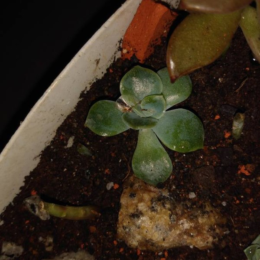

In [10]:
for i in range(3):
    for j in range(len(train_ds.img_names)):
        label = train_ds.labels[j]
        name = train_ds.img_names[j]

        display(Resize(INPUT_SIZE)(Image.open(os.path.join(train_ds.img_dir, str(label), name))))
        break

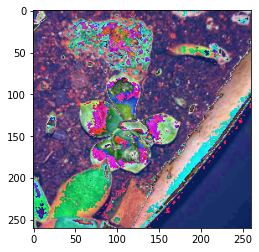

In [11]:
for i in range(3):
    for image, label in train_ds:    
        plt.imshow(ToPILImage()(image))
        plt.show()

        break

## 1.5 Visualize data distribution
We define a helper method that counts the occurrences of each label and plots the resulting dataframe as a histogram.

In [12]:
def plot_image_distribution(df):
    count_df = df['labels'].value_counts().to_frame()
    count_df['id'] = count_df.index
    
    fig, ax = plt.subplots(figsize=(30,10))

    # seaborn histogram
    sns.barplot(data=count_df, x='id', y='labels', ax=ax)
    sns.color_palette("pastel")
    
    # Add labels
    plt.title('Images per class',fontweight='bold', fontsize=16)
    plt.xlabel('Class',fontweight='bold', fontsize=13)
    plt.xticks(rotation=90)
    plt.ylabel('Tot. images', fontweight='bold', fontsize=13)
    
    return count_df.drop('id', axis=1)

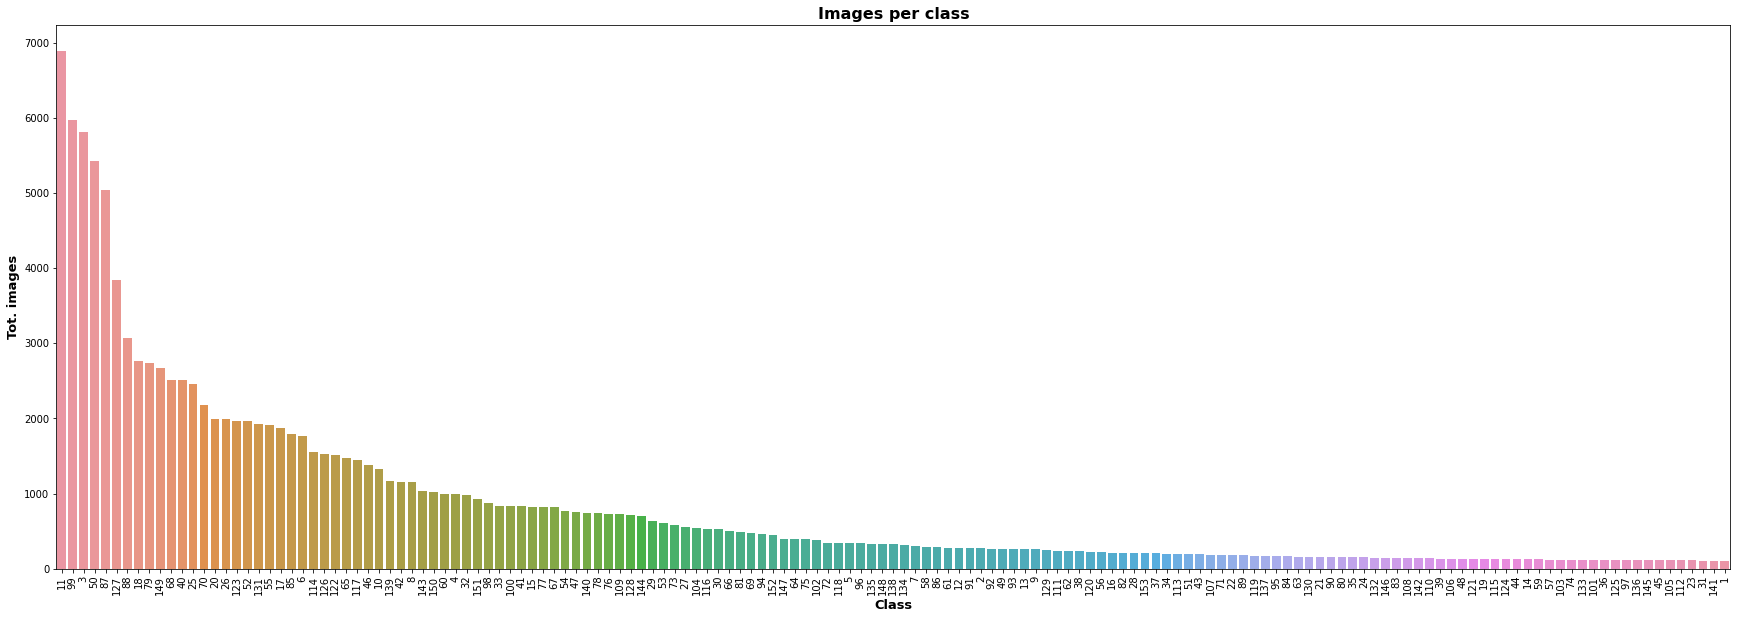

In [13]:
counts = plot_image_distribution(pd.DataFrame(train_ds.labels, columns=["labels"]))

### Notes
We can notice an evident unbalancing among the different classes. However, only about 1/4 of the classes has a number of samples greater than 1000, meaning that the unbalancing may not be so much relevant. In fact, this is our case. We did not use any kind of class balancing technique because our model did not struggle in predicting classes with less samples (see Section 4.1).

The following cell is indeed intended to give a different weight to each class. However, after running some experiments, we decided not to use it, but we included it for sake of completeness.

In [14]:
N_CLASSES = 153
weights_dict = {}

for i in range(len(counts)):
    k = counts.iloc[i, :].name
    n_samples_i = counts.iloc[i, :].values[0]
    #weights_dict[int(k)] = len(train_ds) / (N_CLASSES * n_samples_i)
    if n_samples_i > 3000:
        weights_dict[int(k)] = 0.5
    elif n_samples_i > 1500:
        weights_dict[int(k)] = 0.7
    else:
        weights_dict[int(k)] = 1.0

weights = [weights_dict[k] for k in sorted(weights_dict.keys())]

# 2. Network

## 2.1 Custom module and helper methods definition 

### 2.1.1 Custom module definition

Here we create a custom Network starting from PyTorch's **LightningModule**. We re-implemented some functions such as the constructor, where we allow code re-usability for a variety of architectures (actually those we used in our experiments). We also optimized the usage of GPU, freeing up memory as soon as a batch is used by the model for training or validating. \
We integrated as well the possibility to use a Learning Rate Scheduler, in our case `ReduceLROnPlateau`, since it was the only one allowing us to monitor a metric instead of just decreasing the learning rate basing on the number of epochs. We decided to monitor the validation loss, that is the same metric used for the **Early Stopping**, every epoch and to decrease the learning rate by a factor of 10 when the loss does not improve for 2 consecutive epochs. \
The network can be used for **transfer learning** because of the function `unfreeze()` that sets to `True` the `requires_grad` parameter of each layer of the network. It also reduces the learning rate, or allows the user to use a new one, so that the fine-tuning process can proceed with smaller steps to avoid divergence.

In [15]:
class Network(pl.LightningModule):

    def __init__(self, initial_lr=1e-3, model='resnet50', use_lr_scheduler=False):
        super().__init__()
        
        n_classes = 153
        
        if model in 'resnet50':
            self.net = torchvision.models.resnet50(pretrained=True)
            self.net.fc = nn.Linear(in_features=self.net.fc.in_features, out_features=n_classes, bias=True)
        elif model in 'resnet18':
            self.net = torchvision.models.resnet18(pretrained=True)
            self.net.fc = nn.Linear(in_features=self.net.fc.in_features, out_features=n_classes, bias=True)
        elif model in 'resnet152':
            self.net = torchvision.models.resnet152(pretrained=True)
            self.net.fc = nn.Linear(in_features=self.net.fc.in_features, out_features=n_classes, bias=True)
        elif model == 'vgg19_bn':
            self.net = torchvision.models.resnet50(pretrained=True)
            self.net.classifier[-1] = nn.Linear(in_features=self.net.classifier[-1].in_features, out_features=n_classes, bias=True)
        elif model in ['efficientnet-b0',
                       'efficientnet-b1', 
                       'efficientnet-b2', 
                       'efficientnet-b3', 
                       'efficientnet-b4', 
                       'efficientnet-b5', 
                       'efficientnet-b6', 
                       'efficientnet-b7']: 
            self.net = EfficientNet.from_pretrained(model)
            self.net._fc = nn.Linear(in_features=self.net._fc.in_features, out_features=n_classes, bias=True)
        else:
            raise Exception("Model not supported. Models available: \n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n%s\n" % ('resnet50', 
                                                                                                                           'resnet19', 
                                                                                                                           'resnet152', 
                                                                                                                           'vgg19_bn', 
                                                                                                                           'efficientnet-b0',
                                                                                                                           'efficientnet-b1', 
                                                                                                                           'efficientnet-b2', 
                                                                                                                           'efficientnet-b3', 
                                                                                                                           'efficientnet-b4', 
                                                                                                                           'efficientnet-b5', 
                                                                                                                           'efficientnet-b6', 
                                                                                                                           'efficientnet-b7'))
        
        self.net = self.net.cuda()
        
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy()
        
        for param in self.net.parameters():
            param.requires_grad = True
            
        if model in ['resnet50', 'resnet19', 'resnet152']:
            for param in self.net.fc.parameters():
                param.requires_grad = False
        elif model == 'vgg19_bn':
            for param in self.net.classifier.parameters():
                param.requires_grad = False
        elif model in ['efficientnet-b2', 'efficientnet-b3']: 
            for param in self.net._fc.parameters():
                param.requires_grad = False
        
        self.frozen = True
        
        self.lr = initial_lr
        self.initial_lr = initial_lr
        self.use_lr_scheduler = use_lr_scheduler

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x = batch[0]
        labels = batch[1]
        
        x = x.cuda()
        labels = labels.cuda()
        
        y = self.net(x)

        loss = self.criterion(y, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log("train_acc", self.accuracy(y, labels), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        del x
        del labels
        torch.cuda.empty_cache()
        
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        labels = batch[1]
        
        x = x.cuda()
        labels = labels.cuda()
        
        y = self.net(x)

        loss = self.criterion(y, labels)
        self.log("val_loss", loss)
        self.log("val_acc", self.accuracy(y, labels), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        del x
        del labels
        torch.cuda.empty_cache()
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.net.parameters()), lr=self.lr)
        
        if self.use_lr_scheduler:
            return {"optimizer": optimizer,
                    "lr_scheduler": {
                                    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                                            patience=2, 
                                                                                            min_lr=self.lr/20., 
                                                                                            verbose=True),
                                    "monitor": "val_loss",
                                    "frequency": 1
                                    }
                   }
        else:
            return optimizer

    def unfreeze(self, new_lr):
        self.frozen = False
        for param in self.net.parameters():
            param.requires_grad = True
        
        if new_lr is None:
            self.lr = self.initial_lr 
            self.lr /= 10.0
        else:
            self.lr = new_lr

### 2.1.2 Helper methods definition

Here we define 3 methods used to simplify the training pipeline:
1. `split_dataset()`: splits a given dataset into training and validation sets, according to a split percentage that can be defined by the users (so we did us, using a percentage of 15% for validation set)
2. `fit()`: trains the given network with **Early Stopping**, with or without weights loading, and saves weights of the best model at the end of each training session, which involves the usage of the `Trainer` class of `pytorch-lightning` library
3. `transfer_learning()`: allows to both train a model using transfer learning or from scratch

In [16]:
def split_dataset(ds, val_split=0.1):

    N_val_samples = round(val_split * len(ds))

    ## Split into two Subset
    train, valid = torch.utils.data.random_split(ds, [len(ds) - N_val_samples, N_val_samples])

    return train, valid


def fit(net, train_dl, val_dl, kwargs, bs=64, patience=3, max_epochs=10, new_lr=None, logger=None, weights_path=None, unfreeze=False, finetune=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', verbose=True, patience=patience, check_on_train_epoch_end=False)
    
    if weights_path is not None:
        net.net.load_state_dict(torch.load(weights_path))
        
    if unfreeze:
        net.unfreeze(new_lr)
          
    trainer = pl.Trainer(gpus=1,
                         max_epochs=max_epochs,
                         fast_dev_run=False,
                         callbacks=[early_stopping],
                         checkpoint_callback=True,
                         logger=logger)
    trainer.tune(net, train_dl, val_dl)
    trainer.fit(net, train_dl, val_dl)
    
    # load best model
    net = Network.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, **kwargs)
    
    # save weights
    out_dir = "/kaggle/working"
    os.chdir(out_dir)
    
    # if we are training without weights, we save the weights of the first part
    if not finetune:
        save_path = "weights_first_part.pth"
    else:
        save_path = "weights_second_part.pth"
    
    torch.save(net.net.state_dict(), save_path)
    
    return net, save_path


def transfer_learning(net, train_dl, val_dl, kwargs, bs=64, patience=3, max_epochs=10, new_lr=None, logger=None, weights_path=None, finetune=False):
    
    # train without weights
    if weights_path is None:
        if not finetune:
            return fit(net, 
                       train_dl, 
                       val_dl,
                       kwargs,
                       bs=bs, 
                       patience=patience, 
                       max_epochs=max_epochs, 
                       new_lr=new_lr,
                       logger=logger, 
                       unfreeze=False)
        else:
            return fit(net, 
                       train_dl, 
                       val_dl,
                       kwargs,
                       bs=bs, 
                       patience=patience, 
                       max_epochs=max_epochs, 
                       new_lr=new_lr,
                       logger=logger, 
                       unfreeze=True,
                       finetune=finetune)
    # train with weights
    else:
        return fit(net, 
                   train_dl, 
                   val_dl,
                   kwargs,
                   bs=bs, 
                   patience=patience, 
                   max_epochs=max_epochs,  
                   new_lr=new_lr,
                   logger=logger, 
                   weights_path="./" + weights_path,
                   unfreeze=True)

## 2.2 Training

### 2.2.1 Training/Validation split
We use 85% of the training dataset for training, and the remaining 15% for validation. This percentage has been chosen after some experiments, but the reasoning behind it is that we have more than 120000 images for training, hence using 15% of them (about 18000) will keep the validation set as large as the test set, providing us a more precise unbiased estimate of test accuracy.

In [17]:
train_set, val_set = split_dataset(train_ds, val_split=0.15)

### 2.2.2 DataLoaders creation
We create here the DataLoaders used to load both training and validation sets in the network. The **batch size** has been chosen basing on the maximum amount of GPU memory we could have used. In our case, using a batch size of 64 resulted in using more than the available GPU memory, so we decided to reduce it to 32, sacrifying a bit of computational speed on training.

In [18]:
BATCH_SIZE = 32

train_dl = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=8)
val_dl = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, num_workers=8)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
logger = pl.loggers.TensorBoardLogger(save_dir='/kaggle/working', log_graph=True)

### 2.2.3 Network instantiation and training

Now, we can finally instanciate our network, passing some parameters to the `Network` class, such as the model to use and the initial learning rate. \
Then we proceed with the actual training pipeline, where we first train only the Fully-Connected layers of our network, then we unfreeze it (all the layers are trainable now), and we retrain it with a lower learning rate. The transfer learning choice has been made to first "align" the FCN weights to those of CNN, then to train CNN+FCN to solve the same problem (classification of our plant images, and not images from ImageNet dataset). \
After each training part, weights are saved to save training time in future sessions. For example, weights for the first part can be reused as a starting point if one wants to only change the setting of the second training part or to start the second training session another time. This also allows us to have a more flexible pipeline.

**Note**: in this notebook we used weights coming from the first training part obtained in a previous session, where we trained the model with the same parameter that are written here, but without transformation. Then, we are here running directly the second training phase, this time using transformations on the dataset.

In [20]:
kwargs = {
    'initial_lr': 1e-3, 
    'model': 'efficientnet-b2', 
    'use_lr_scheduler': False
}

net = Network(**kwargs)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [ ]:
# first training part
net, weights_path = transfer_learning(net, 
                                      train_dl, 
                                      val_dl,
                                      kwargs,
                                      bs=BATCH_SIZE, 
                                      patience=2, 
                                      max_epochs=10,  
                                      finetune=False)

In [ ]:
FileLink(weights_path)

In [21]:
# second training part (fine-tuning)
weights_path = 'weights_first_part.pth'
net, weights_path = transfer_learning(net, 
                                      train_dl, 
                                      val_dl,
                                      kwargs,
                                      bs=BATCH_SIZE, 
                                      patience=4, 
                                      max_epochs=25, 
                                      logger=logger, 
                                      new_lr=1e-5,
                                      weights_path="./" + weights_path, # <- uncomment this to train with weights
                                      finetune=True)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:237: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Loaded pretrained weights for efficientnet-b2


In [25]:
net = Network.load_from_checkpoint("./default/version_0/checkpoints/epoch=2-step=10052.ckpt", **kwargs)

Loaded pretrained weights for efficientnet-b2


In [22]:
FileLink(weights_path)

/kaggle/working/weights_first_part.pth

# 4. Experiments

## 4.1 Plot performance statistics
In this section, we will plot:
1. confusion matrix and final accuracy
2. the number of errors made on validation for each class
3. the classification report
4. a graph showing the variation of the F1-score basing on each class 

### 4.1.1 Confusion matrix and final accuracy

#### 4.1.1.1 Helper method definition

This method computes the predicted labels for a given dataset. It requires, of course, the model, and the DataLoader used to load such dataset.  

In [26]:
def get_confusion_matrix(model, dl):
    model = model.cuda()
    model.eval()
    
    predictions = []
    true_labels = []

    for i, (inputs,targets) in tqdm(enumerate(dl)):
        inputs = inputs.cuda()
        pred = model(inputs).data.cuda().cpu().numpy().copy()
            
        predictions.append(pred)
        true_labels.append(targets)
    
    y_pred = np.concatenate(predictions).argmax(1)
    y_true = np.concatenate(true_labels)
    
    return y_pred, y_true, confusion_matrix(y_true,y_pred)

#### 4.1.1.2 Plot confusion matrix

In [27]:
val_dl.__batch_size = 1
y_pred, y_true, conf_matrix = get_confusion_matrix(net, val_dl)

0it [00:00, ?it/s]

In [28]:
f,ax = plt.subplots(figsize=(50, 50))
plot = sns.heatmap(conf_matrix, annot=True, ax=ax, fmt='g')
plot.set_xticklabels(range(1, N_CLASSES+1));
plot.set_yticklabels(range(1, N_CLASSES+1));

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f096142f4d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f0961d9ff80> (for post_execute):


KeyboardInterrupt: 

#### 4.1.1.3 Print final accuracy

In [34]:
print("Final accuracy on validation:", accuracy_score(y_pred, y_true))

Final accuracy on validation: 0.9170762644680513


### 4.1.2 Errors on validation for each class

#### 4.1.2.1 Create DataFrame showing models' misclassifications

In [35]:
classes = range(1, N_CLASSES+1)
errors = []

for i in range(conf_matrix.shape[0]):
    errors.append(conf_matrix[i, i+1:].sum())
    
error_df = pd.DataFrame(errors, columns=['errors'], index=classes)
error_df.sort_values(by='errors', ascending=False)

,errors
78,122
4,111
33,70
3,42
18,39
...,...
122,0
91,0
124,0
125,0


#### 4.1.2.2 Visualize results

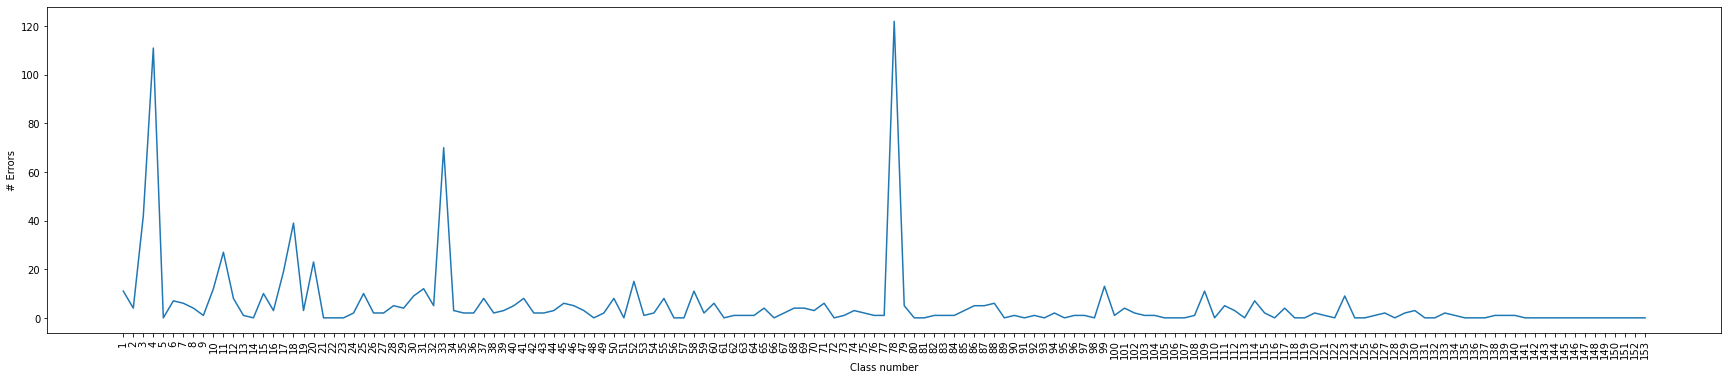

In [36]:
plt.figure(figsize=(30,6))
plt.plot(error_df.errors)
plt.xticks(error_df.index, rotation = 90)
plt.xlabel("Class number")
plt.ylabel("# Errors")
plt.show()

### 4.1.3 Print classification report

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.42      0.53        19
           1       0.96      0.92      0.94        51
           2       0.96      0.95      0.96       863
           3       0.48      0.22      0.30       142
           4       0.98      1.00      0.99        48
           5       0.87      0.97      0.92       252
           6       0.80      0.83      0.81        42
           7       0.99      0.98      0.99       174
           8       1.00      0.98      0.99        43
           9       0.95      0.94      0.95       210
          10       0.98      0.97      0.98      1004
          11       0.97      0.79      0.87        39
          12       0.85      0.97      0.91        35
          13       0.88      0.96      0.92        24
          14       0.96      0.92      0.94       129
          15       0.86      0.91      0.89        35
          16       0.96      0.94      0.95       306
          17       0.90    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.1.4 Plot F1 score for each class

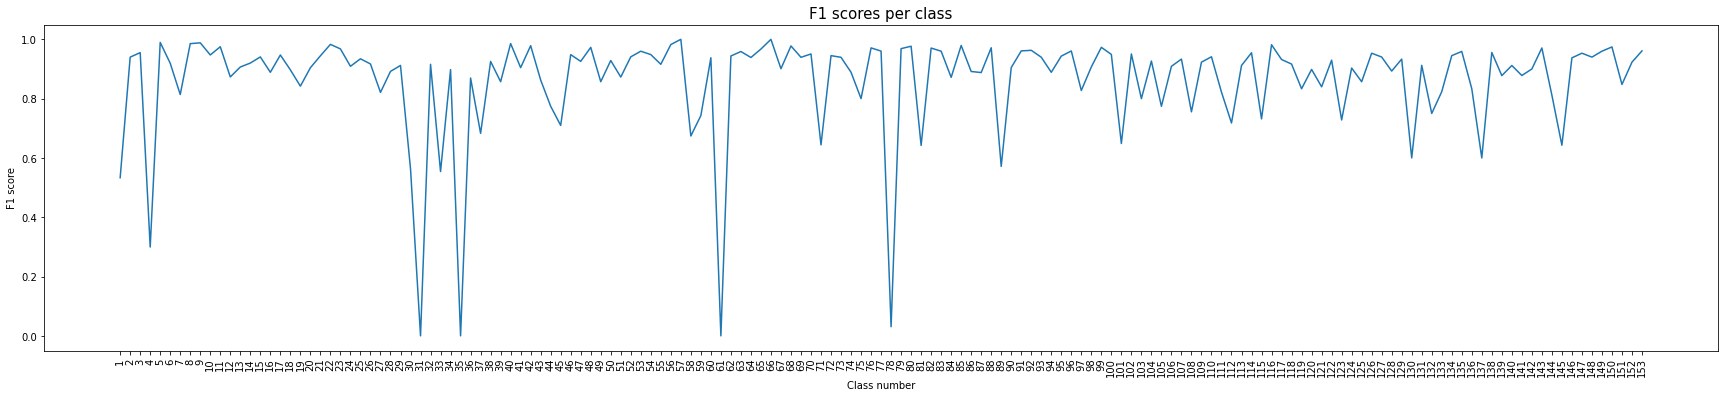

In [38]:
plt.figure(figsize=(30,6))
plt.plot(range(1, N_CLASSES+1), f1_score(y_true, y_pred, average=None))
plt.xticks(error_df.index, rotation = 90)
plt.title("F1 scores per class", fontsize=15)
plt.xlabel("Class number")
plt.ylabel("F1 score")
plt.show()

## 4.2 Submission file generation

### 4.2.1 Compute predictions for test set

In [39]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=8)
predictions = {}
net.eval()
net = net.cuda()

for i, sample in enumerate(tqdm(test_dl)):
    x = sample[0].cuda()
    name = sample[1][0]
    
    y = nn.functional.softmax(net(x))
    y = y.cpu()
    
    predictions[name] = np.argmax(y.detach().numpy()) + 1

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/14115 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


### 4.2.2 Create DataFrame to export .csv

In [40]:
df = pd.DataFrame(predictions.values(), columns=["class"], index = predictions.keys())
df.index.names = ["image_name"]
df

,class
image_name,
7981.jpg,18
12666.jpg,79
13288.jpg,51
6234.jpg,99
1269.jpg,149
...,...
8152.jpg,5
3361.jpg,10
2599.jpg,16


### 4.2.3 Display some predictions
Here we display some test images with their respective predicted labels

In [41]:
class_names_df = pd.read_csv("/kaggle/input/polytech-nice-data-science-course-2021/polytech/class_names.csv")

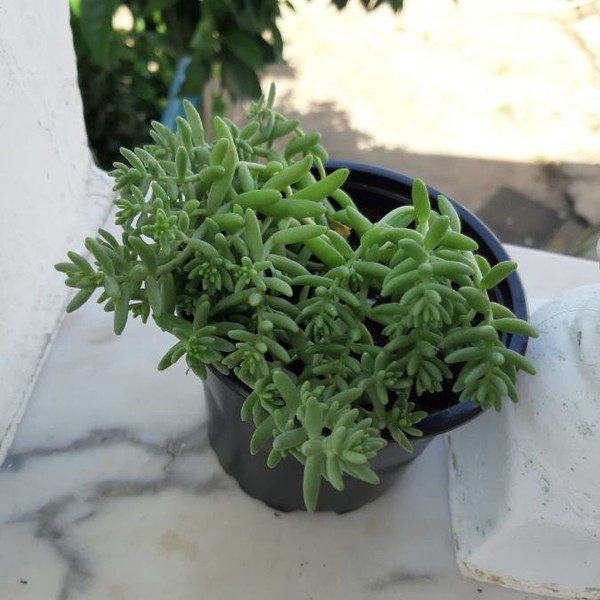

Predicted label: 18
Corresponding class name: Sedum_album



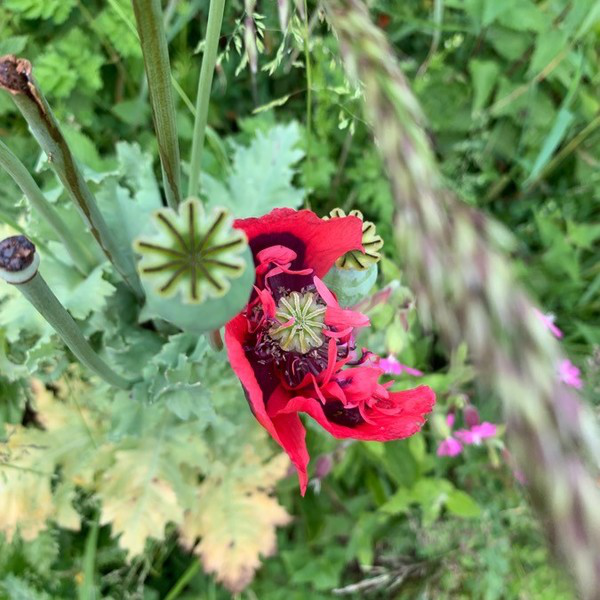

Predicted label: 79
Corresponding class name: Papaver_somniferum



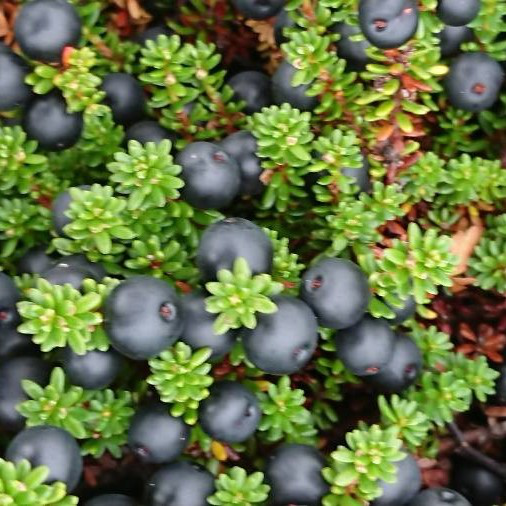

Predicted label: 51
Corresponding class name: Empetrum_nigrum



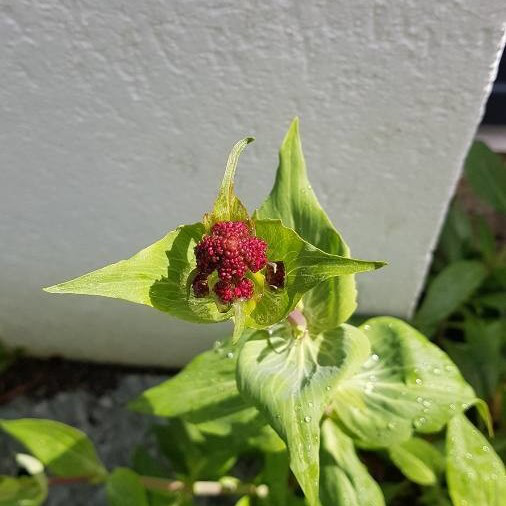

Predicted label: 99
Corresponding class name: Centranthus_ruber



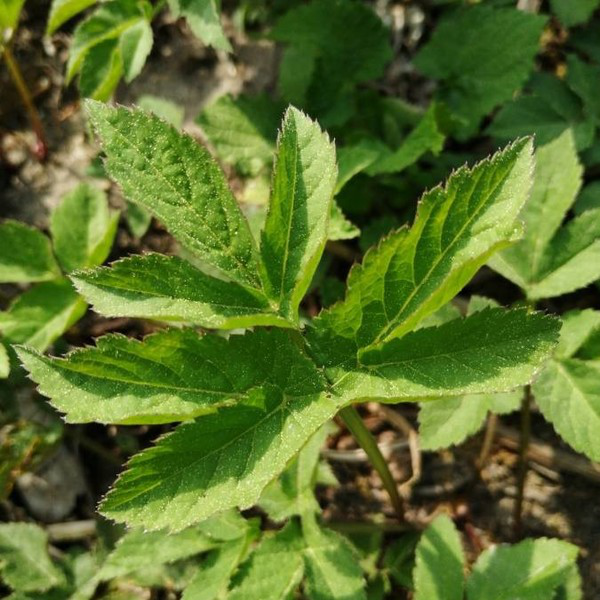

Predicted label: 149
Corresponding class name: Aegopodium_podagraria



In [42]:
iteration = 0
for image in test_ds.img_names:
    iteration += 1
    
    path = os.path.join(test_ds.img_dir, image)
    
    display(Image.open(path).convert("RGB"))
    
    pred = predictions[image]
    print("Predicted label: {}".format(pred))
    print("Corresponding class name: {}\n".format(class_names_df[class_names_df["id_species"] == pred].iloc[:, -1].values[0]))
    
    if iteration == 5:
        break

### 4.2.5 Save predictions in .csv file

In [43]:
CSV_NAME = "submission.csv"

df.to_csv(CSV_NAME)
FileLink(CSV_NAME)

/kaggle/working/submission.csv

# 5. Progress
Steps toward the final solution involved the following:
1. First network trained was VGG-19 with Batch Normalization. It had 67% accuracy on validation, but it had too many parameters, requiring too much time to be trained.
2. Resnet152 was our next choice, because it is a very well performing state-of-the-art model. Using pretrained weights from ImageNet dataset, we have been able to reach 83% accuracy on validation
3. We tried to reduce the depth of ResNet, using ResNet50 and ResNet18. While the first one gave us a little improvement, the other didn't present any significant difference with ResNet50. Hence, we decided to further train the latter, using ReduceLROnPlateau scheduler to reduce the learning rate each time the validation loss increased. This led us to achieve almost 86% accuracy.

When we reached this point, we wanted to use weights to balance classes. However, our model was perfect at predicting classes with few samples, as well as classes with large number of samples. Hence, we decided not to use class balancing techniques (such as oversampling) because it wasn't the main problem afflicting our model. \
We also tried to use transformations at this point, but they didn't improve our accuracy.

Finally, we had a look at [torchvision documentation](http://pytorch.org/vision/stable/models.html), discovering a new model called **EfficientNet**, which was the best performing one on ImageNet dataset. There are 8 types of this model, from B0 to B7, and we decided to use B2 model because of a trade-off between model's strength and GPU memory space required to train it. \
We used pretrained weights, achieving an 87% accuracy by training it from scratch. Then, by applying transformations and using transfer learning, we have been able to improve our accuracy by 1%, while the same strategy, but without transformations, led our model to get an 89% accuracy.

# 6. Conclusion
To conclude this analysis, we still notice some struggles for the model to predict some classes. A way to improve this problem may be to look at the test samples having these same classes, and perform transformations on training samples basing on test samples. For example, if one discovers that test images are rotated, it can be applied a rotation to train images in order for the model to be able to recognize those images at test time and, hence, correctly predict them. \
Said that, the model has almost a 90% accuracy on test set, meaning that to improve it, one can either perform specific tasks as the one mentioned above or use a more advanced architecture, such as EfficientNet-B7. Clearly, this kind of improvement also depends on the resources available, which in case of Kaggle has not been possible.